# Анализ датасета

Датасет собран следующим образом:

- Из логов были взяты пары ([запрос] - [объект на который кликнул пользователь]). Это положительные примеры (метка 1 в датасете)
- Для каждого запроса был подобран в пару негативный объект (метка 0) следующим образом: определяем к какой рубрике относится положительный пример; выбираем случайный объект из другой рубрики. Идея в том, что этот пример маловероятно будет релевантным.

На этих данных, используя кросс-валидацию, обучались различные модели. Метрики качества были хорошими.
При попытки тестирования на реальных данных, качество моделей сильно уступало тестовым метрикам.


**Задача**: выявить особенности датасета, которые приводили к данным результатам и объяснить почему так происходило.


### Загрузка библиотек и данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/datasets/clicks_dataset_msk_20230101_20230725_spec.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
df = pd.read_csv('clicks_dataset_msk_20230101_20230725_spec.csv', names=['query', 'object', 'target'])

In [6]:
df.shape

(12979882, 3)

- **query** – ID запроса
- **object** – ID объекта на который кликнул пользователь
- **target** - метка класса

In [7]:
df.head(15)

,query,object,target
0,1590973,168299,1
1,1590973,718560,0
2,1234953,325828,1
3,1234953,135968,0
4,3326557,334526,1
5,3326557,541953,0
6,4092778,153837,1
7,4092778,846445,0
8,472877,157611,1
9,472877,405852,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12979882 entries, 0 to 12979881
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   query   int64
 1   object  int64
 2   target  int64
dtypes: int64(3)
memory usage: 297.1 MB


### Проверка баланса классов

In [9]:
df['target'].value_counts(normalize=True)

1   0.500
0   0.500
Name: target, dtype: float64

Классы по таргету сбалансированы.

### Уникальность запросов и объектов

In [10]:
df.nunique()

query     4520364
object    1154540
target          2
dtype: int64

In [11]:
print('Доля уникальных запросов составляет', f"{round(df['query'].nunique() / len(df) * 100, 2)}%")

Доля уникальных запросов составляет 34.83%


In [12]:
print('Доля уникальных объектов составляет', f"{round(df['object'].nunique() / len(df) * 100, 2)}%")

Доля уникальных объектов составляет 8.89%


In [13]:
query_distribution = df['query'].value_counts()
object_distribution = df['object'].value_counts()

In [14]:
query_distribution.head(15)

1612834    31864
1863671    28594
2798020    22562
1473816    21864
580239     19684
1269128    19298
2711692    18288
3423161    15314
1912512    14822
3833853    13842
3760248    13068
3325022    12988
2598575    10596
1863675    10144
2484586     9602
Name: query, dtype: int64

In [15]:
object_distribution.head(15)

135367    2838
161420    2698
128803    2012
91490     1947
356746    1926
82019     1880
623130    1778
76237     1758
392020    1755
130293    1751
334279    1750
740625    1737
82029     1598
342216    1466
334854    1348
Name: object, dtype: int64

In [16]:
df[df['query'] == 1612834]

,query,object,target
704,1612834,377421,1
705,1612834,675014,0
830,1612834,714093,1
831,1612834,398929,0
1060,1612834,74546,1
...,...,...,...
12978277,1612834,95632,0
12978334,1612834,570223,1
12978335,1612834,146934,0
12979548,1612834,558344,1


In [17]:
df[df['object'] == 135367]

,query,object,target
6852,995129,135367,1
7510,618818,135367,1
10388,617874,135367,1
15568,3367431,135367,1
17226,521207,135367,1
...,...,...,...
12963116,620552,135367,1
12971858,4229324,135367,1
12973618,630556,135367,1
12975576,461293,135367,1


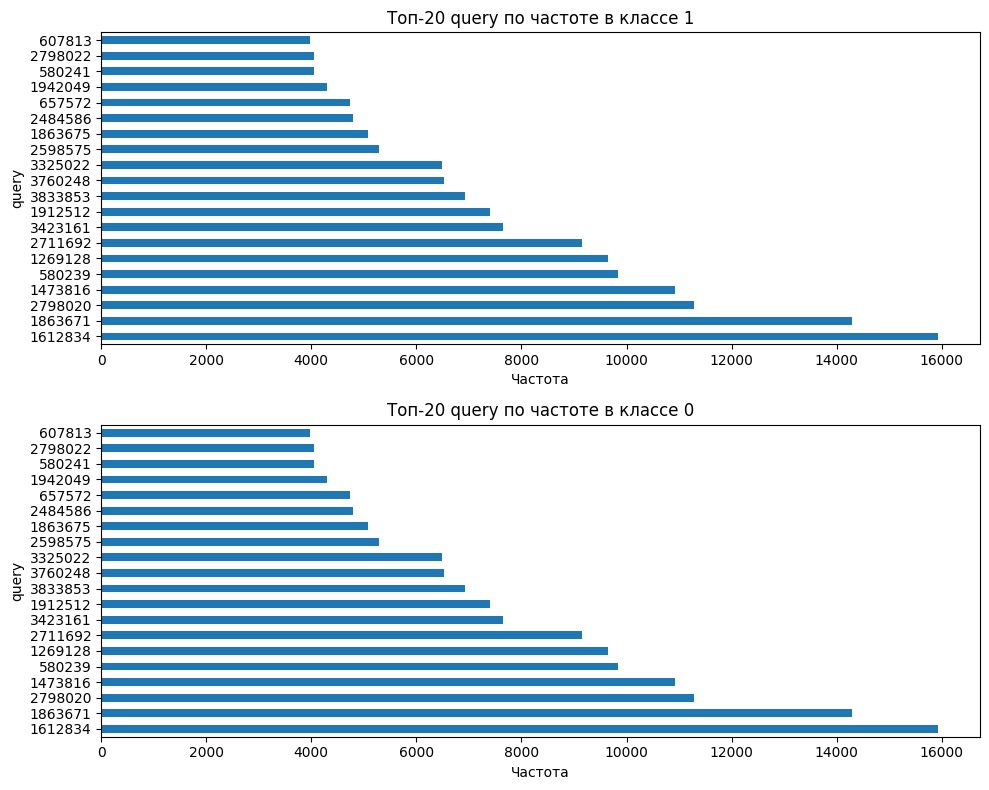

In [18]:
def visualize_top_counts(data, top, kind, target):
    d = data[df['target']==target][kind].value_counts()
    d.head(top).plot(kind='barh')
    plt.title(f'Топ-{top} {kind} по частоте в классе {target}')
    plt.xlabel('Частота')
    plt.ylabel(kind)

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
visualize_top_counts(df, top=20, kind='query', target=1)

plt.subplot(2, 1, 2)
visualize_top_counts(df, top=20, kind='query', target=0)

plt.tight_layout()
plt.show()

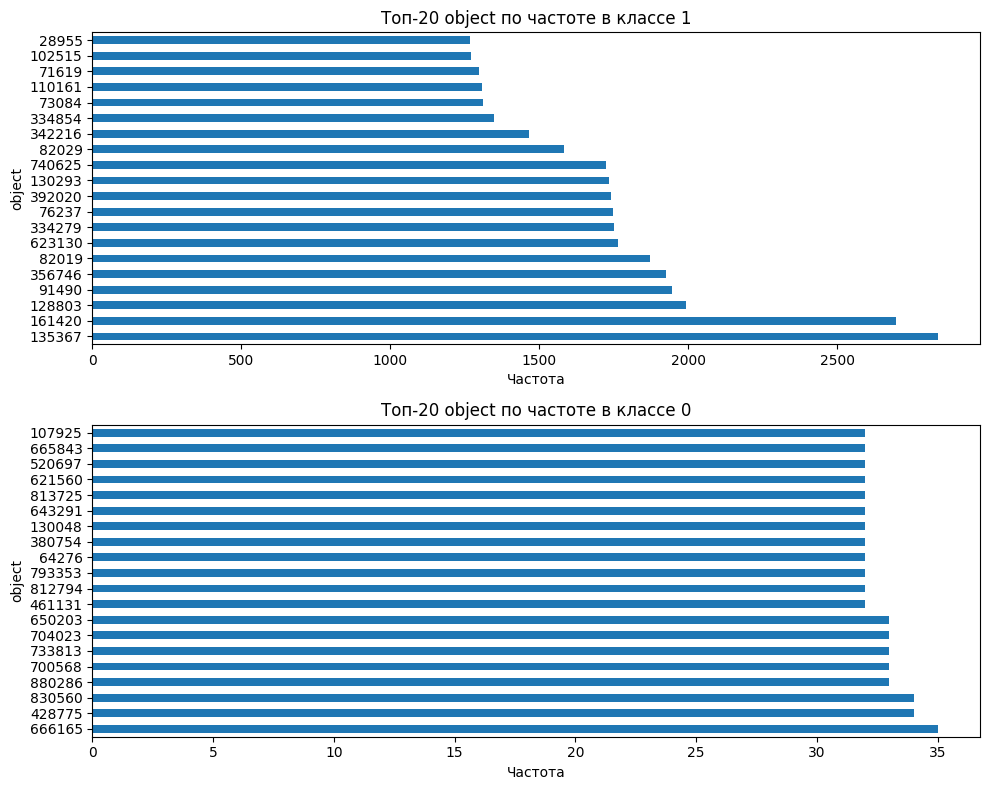

In [19]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
visualize_top_counts(df, top=20, kind='object', target=1)

plt.subplot(2, 1, 2)
visualize_top_counts(df, top=20, kind='object', target=0)

plt.tight_layout()
plt.show()

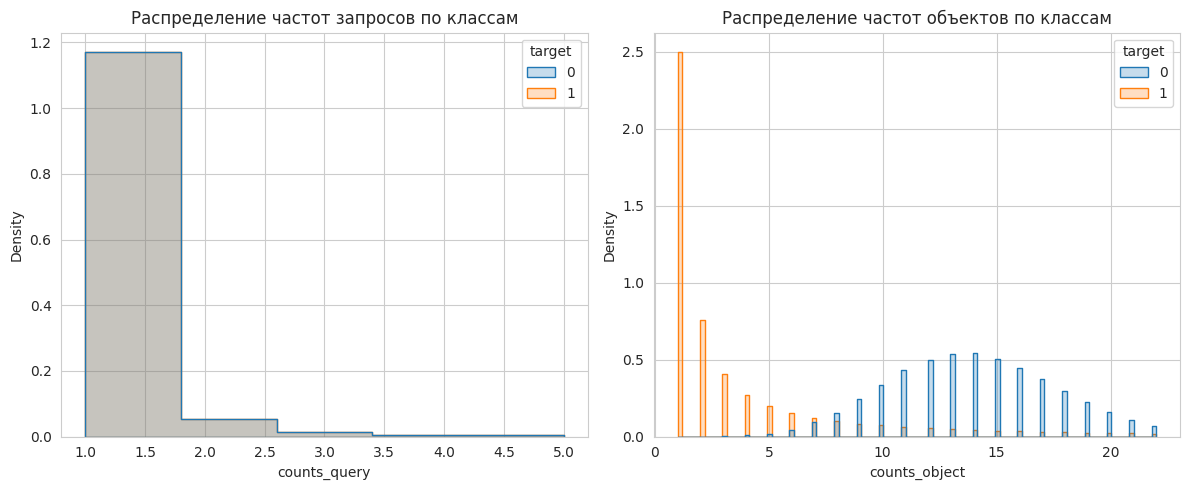

In [31]:
query_counts = df.groupby(['query', 'target']).size().reset_index(name='counts_query')
object_counts = df.groupby(['object', 'target']).size().reset_index(name='counts_object')

# Удаление выбросов
query_threshold = query_counts['counts_query'].quantile(0.99)
object_threshold = object_counts['counts_object'].quantile(0.95)

filtered_query_counts = query_counts[query_counts['counts_query'] <= query_threshold]
filtered_object_counts = object_counts[object_counts['counts_object'] <= object_threshold]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=filtered_query_counts, bins=5, x='counts_query', hue='target', element='step', stat='density', common_norm=False)
plt.title('Распределение частот запросов по классам')

plt.subplot(1, 2, 2)
sns.histplot(data=filtered_object_counts, x='counts_object', hue='target', element='step', stat='density', common_norm=False)
plt.title('Распределение частот объектов по классам')

plt.tight_layout()
plt.show()


На этих гистограммах частот по классам удалены выбросы для улучшения визуализации.

Распределение данных запросов по классам примерно совпадает. А вот по объектам – частоты из разных распредений, что отражается на качестве датасета.

In [21]:
df['query'].value_counts()

1612834    31864
1863671    28594
2798020    22562
1473816    21864
580239     19684
           ...  
309353         2
1638241        2
1707106        2
3747246        2
3008578        2
Name: query, Length: 4520364, dtype: int64

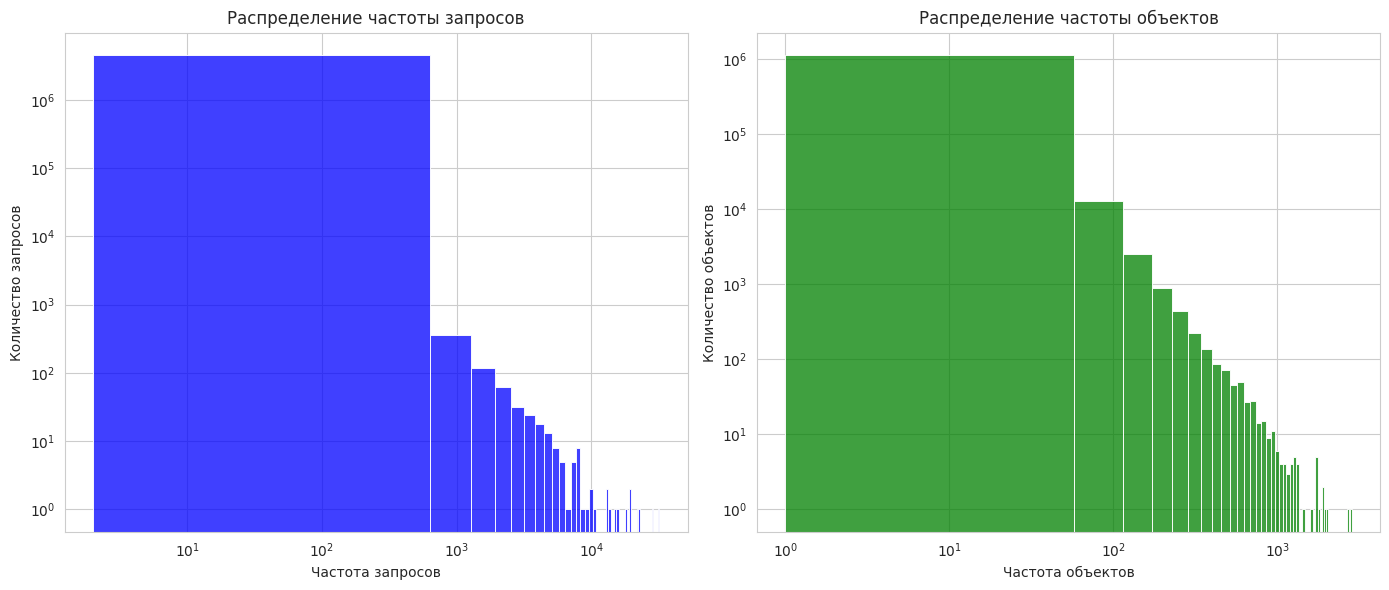

In [22]:
sns.set_style("whitegrid")

def visualize_amount_hist(data, kind, color):
    sns.histplot(data, bins=50, kde=False, color=color)
    plt.title(f'Распределение частоты {kind}')
    plt.xlabel(f'Частота {kind}')
    plt.ylabel(f'Количество {kind}')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)

# Гистограмма распределения частоты запросов
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
visualize_amount_hist(query_distribution, 'запросов', 'blue')

# Гистограмма распределения частоты объектов
plt.subplot(1, 2, 2)
visualize_amount_hist(object_distribution, 'объектов', 'green')

plt.tight_layout()
plt.show()

На  гистограммах видно следующее:

**Распределение частоты запросов**: Большинство запросов появляются относительно редко, но существует небольшое количество запросов с очень высокой частотой появления.

**Распределение частоты объектов**: Аналогичная картина наблюдается и для объектов, где большинство объектов встречается редко, в то время как некоторые объекты появляются гораздо чаще. Это также указывает на несбалансированность в распределении объектов по датасету.

### Исследование пар запрос-объект

In [24]:
print('Количество дубликатов', df.duplicated(subset=['query', 'object'], keep='first').sum())

Количество дубликатов 3994


In [25]:
duplicate_pairs = df[df.duplicated(subset=['query', 'object'], keep=False)].sort_values(['query', 'object'])
duplicate_pairs.shape[0]

7970

In [26]:
pd.concat([df.sample(1000000), duplicate_pairs]).to_csv('sample.csv', index=False)

In [27]:
duplicate_pairs.head(30)

,query,object,target
6181107,48649,126610,0
7610803,48649,126610,0
360739,203168,564481,0
8429076,203168,564481,1
7759261,375422,122062,0
9079595,375422,122062,0
6601851,375422,380543,0
12019513,375422,380543,0
799409,375422,559107,0
3423710,375422,559107,1


In [28]:
duplicates_grouped = duplicate_pairs.groupby(['query', 'object']).size().reset_index(name='counts').sort_values('counts', ascending=False).reset_index(drop=True)
duplicates_grouped

,query,object,counts
0,3217421,92413,3
1,1863671,480496,3
2,2798020,70342,3
3,586644,759793,3
4,1612834,415642,3
...,...,...,...
3971,1612834,688236,2
3972,1612834,688724,2
3973,1612834,688838,2
3974,1612834,693469,2


In [29]:
duplicates_grouped['counts'].value_counts()

2    3958
3      18
Name: counts, dtype: int64

In [30]:
duplicates_class = duplicate_pairs.groupby(['query', 'object'])['target'].nunique()

print('Дубликаты разных классов:', duplicates_class[duplicates_class > 1].count())
print('Дубликаты одного класса:', duplicates_class[duplicates_class == 1].count())

Дубликаты разных классов: 1409
Дубликаты одного класса: 2567


- Всего обнаружено **3994** дубликатов пар запрос-объект,  вместе с оригинальными парами их количество – **7970**. Большинство дубликатов встречаются 1 раз, но есть 18 пар, у которых по 2 дубликата в датасете.
- **1409** пар имеют дубликаты с разными классами. Это означает, что одна и та же пара запрос-объект встречается в датасете с таргетами 0 и 1, что может вводить в заблуждение при обучении модели.
- **2567** пар имеют дубликаты с одинаковыми классами. Такие дубликаты не создают проблемы с точки зрения противоречивой информации, но они увеличивают размер датасета без добавления новой информации, что может привести к переобучению на этих данных.

## Выводы

Были обнаружены следующие особенности датасета:
1. Данные сбалансированы по классам, но по запросам и объектам есть дисбаланс:
  - есть небольшое количество запросов и объектов с очень высокой частотой появления. Возможно, на реальных (в том числе тестовых) данных распределение запросов и объектов такое же, но если нет, то это оказывает сильное влияние на обучение модели и корректность её результатов, модель переобучается на этих рубриках и объектах
  - существуют проблема для тех запросов, которые мало представлены в датасете, модель плохо по ним обучается
2. Наблюдается различная частота встречаемости объектов в разных классах, распределение у них разное.
3. В датасете присутствуют дубликаты пар запрос-объект. Хотя их процентное соотношение невелико, но:
  - есть дубликаты, принадлежащие разным классам, из-за чего модель может обучаться некорректно
  - есть дубликаты одного класса, модель может переобучаться на этих примерах
4. В целом, наличие дубликатов может указывать на ошибки при выборе объектов для нулевого класса и стоит перепроверить методики выбора объекта. Возможно, эти объекты не совсем нерелевантны.